<a href="https://colab.research.google.com/github/bimsaraperera/Deep-Learning-Models/blob/main/MNIST_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = MNIST(root = '/content/drive/MyDrive/HandwrittenNumbers', train = True, transform= torchvision.transforms.ToTensor())

In [ ]:
len(dataset)

60000

In [ ]:
def split_indices(n, val_pct):
  n_val = int(val_pct*n)
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [ ]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)


In [ ]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler = val_sampler)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size1,hidden_size2,out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size,hidden_size1)
    self.linear2 = nn.Linear(hidden_size1,hidden_size2)
    self.linear3 = nn.Linear(hidden_size2, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    return out

In [ ]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,hidden_size1=128,hidden_size2=32,out_size=num_classes)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
model = to_device(model, device)

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  if metric is not None:
    metric_result = metric(preds, yb)

  return loss.item() , len(xb), metric_result

In [ ]:
def evaluate(model, loss_func, valid_dl, metric = None):
  with torch.no_grad():
    results =[loss_batch(model, loss_fn, xb, yb, metric = metric) for xb, yb in valid_dl]
    losses, nums, metrics = zip(*results)
    total = np.sum(nums)
    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    
    if metric is not None:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
    
    return avg_loss,total,avg_metric


In [ ]:
def accuracy(outputs, labels):
  __, preds = torch.max(outputs, dim=1)

  return torch.sum(preds==labels).item()/len(preds)

In [ ]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric = accuracy)
val_loss, val_acc

(2.3032334566116335, 0.04066666666666666)

In [ ]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric = None):
  for epoch in range(epochs):
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt, metric)

    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_acc = result

    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,epochs,val_loss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}:{:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_acc))

In [ ]:
fit(20, model, loss_fn, optimizer, train_loader, val_loader, accuracy)

Epoch [1/20], Loss: 0.3155, accuracy:0.9083
Epoch [2/20], Loss: 0.2268, accuracy:0.9357
Epoch [3/20], Loss: 0.1845, accuracy:0.9472
Epoch [4/20], Loss: 0.1564, accuracy:0.9545
Epoch [5/20], Loss: 0.1348, accuracy:0.9604
Epoch [6/20], Loss: 0.1368, accuracy:0.9588
Epoch [7/20], Loss: 0.1170, accuracy:0.9658
Epoch [8/20], Loss: 0.1067, accuracy:0.9685
Epoch [9/20], Loss: 0.1095, accuracy:0.9672
Epoch [10/20], Loss: 0.1142, accuracy:0.9671
Epoch [11/20], Loss: 0.1042, accuracy:0.9696
Epoch [12/20], Loss: 0.0961, accuracy:0.9710
Epoch [13/20], Loss: 0.1009, accuracy:0.9701
Epoch [14/20], Loss: 0.0924, accuracy:0.9744
Epoch [15/20], Loss: 0.0968, accuracy:0.9732
Epoch [16/20], Loss: 0.0924, accuracy:0.9747
Epoch [17/20], Loss: 0.0985, accuracy:0.9723
Epoch [18/20], Loss: 0.0922, accuracy:0.9742
Epoch [19/20], Loss: 0.0895, accuracy:0.9750
Epoch [20/20], Loss: 0.0890, accuracy:0.9756


In [ ]:
test_dataset = MNIST(root = '/content/drive/MyDrive/HandwrittenNumbers', train = False, transform= torchvision.transforms.ToTensor())

In [ ]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 9  Predicted: 9


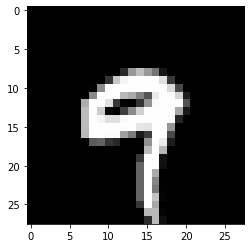

In [ ]:
img, label = test_dataset[4910]
imga = to_device(img,device)
plt.imshow(img[0], cmap='gray')
print('Label:', label, ' Predicted:', predict_image(imga, model))